In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import qnmfits
import utils
import corner
import emcee

from pathlib import Path

plt.rcParams.update(utils.rcparams)

In [2]:
rng = np.random.default_rng()

In [3]:
ID = 1
N = 3
T = 100

modes = [(2, 2, n, 1) for n in range(N+1)]

data_dir = Path('../data/emcee')
run_dir = data_dir / f'ID{ID}_N{N}_t0M_T{T}'

In [4]:
reader = emcee.backends.HDFBackend(run_dir / 'emcee_backend.h5')

In [5]:
tau = reader.get_autocorr_time()

/home/eliot.finch/ringdown/SURF24/.venv/lib64/python3.12/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]


In [6]:
tau

array([nan, nan, nan, nan, nan, nan, nan, nan])

In [7]:
samples = reader.get_chain()

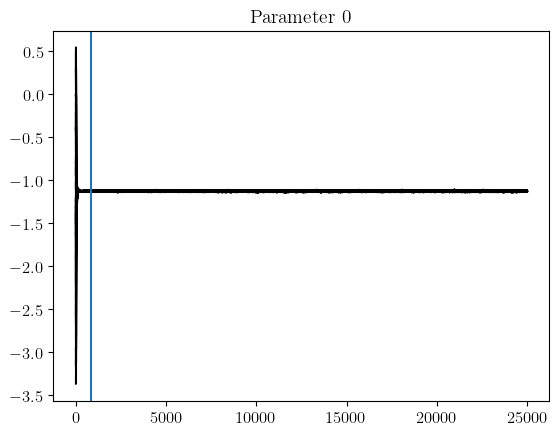

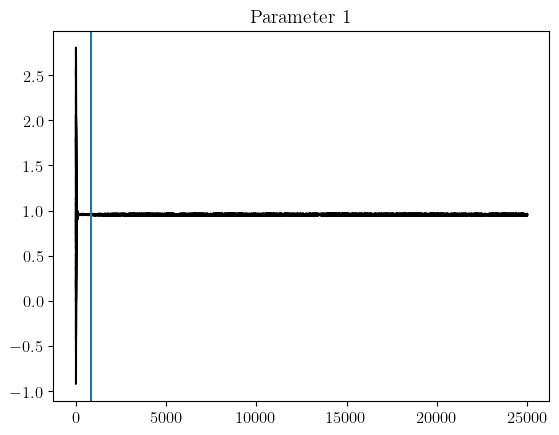

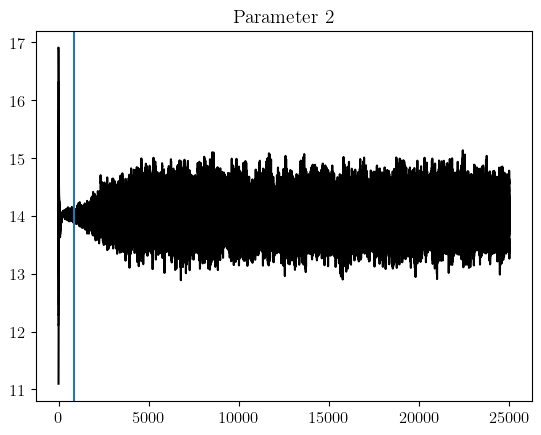

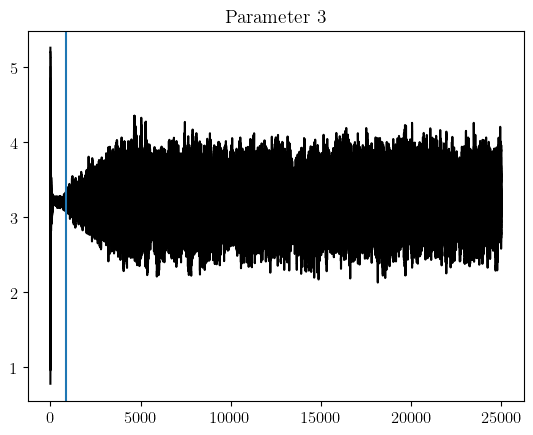

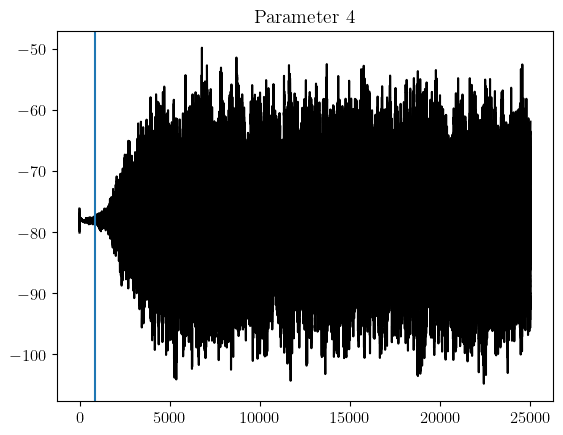

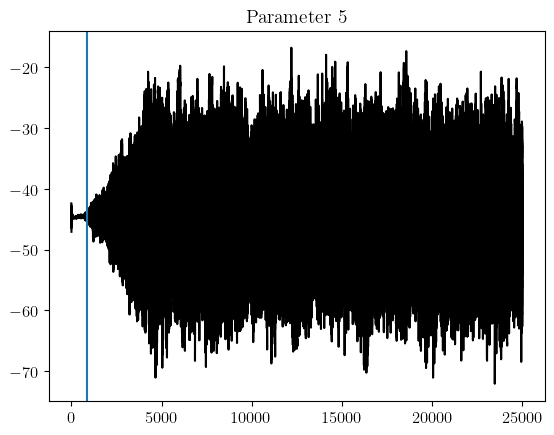

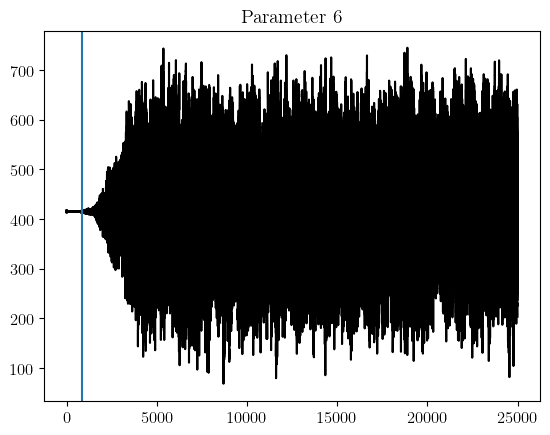

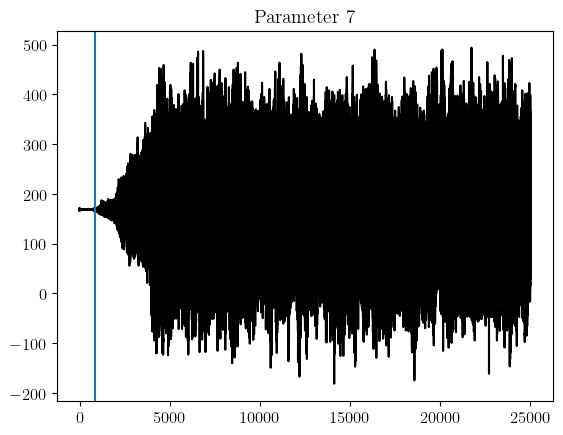

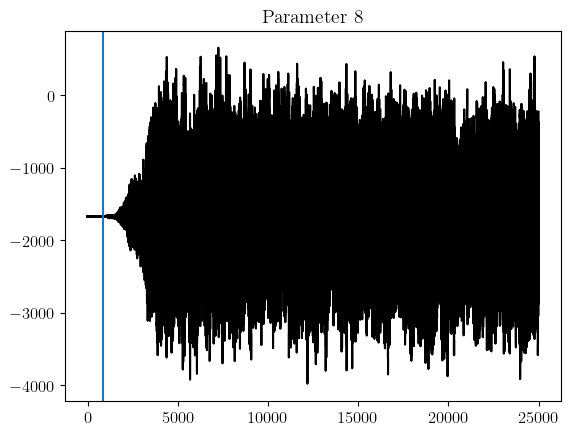

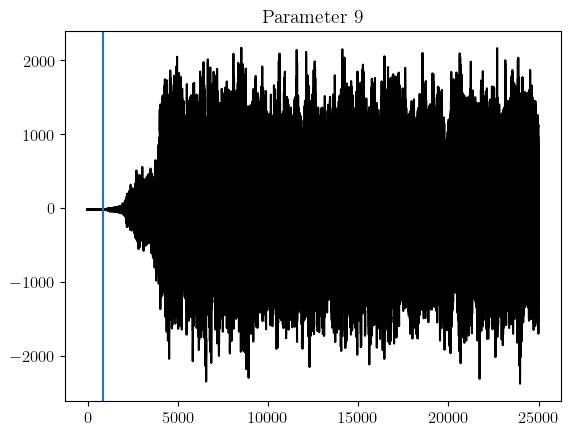

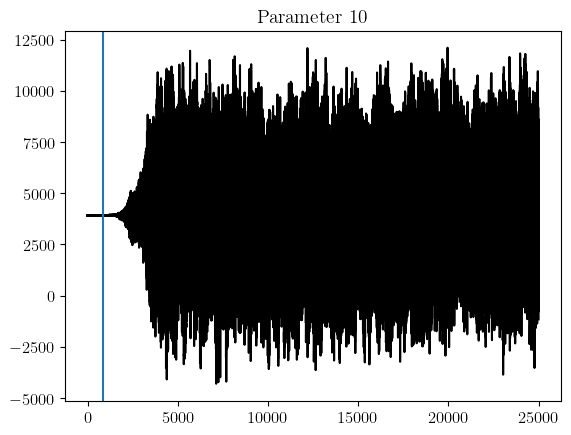

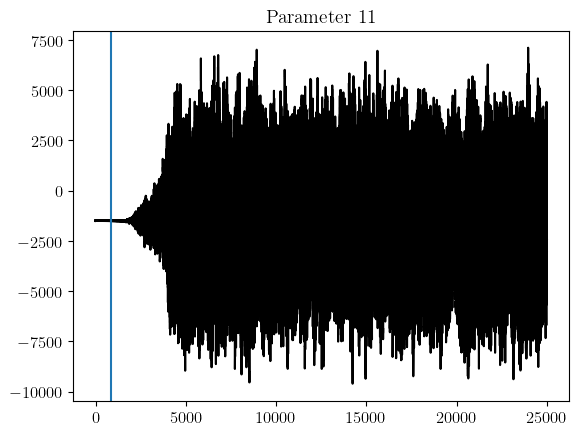

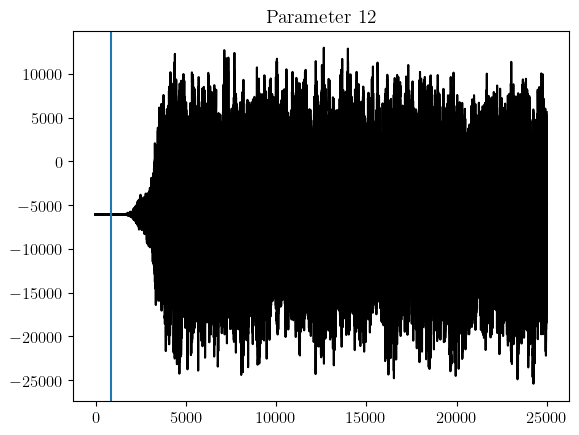

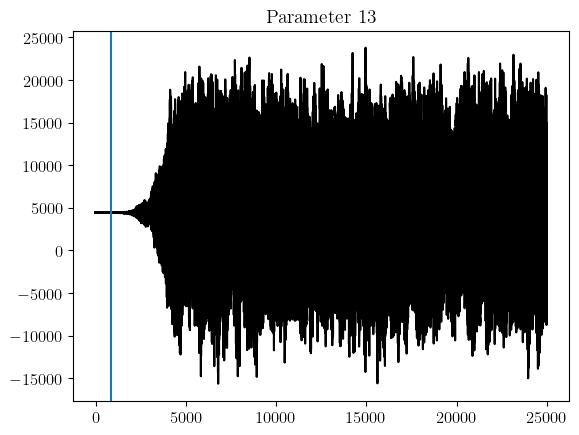

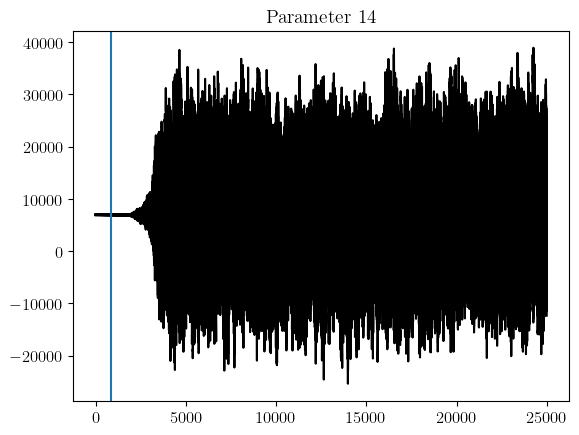

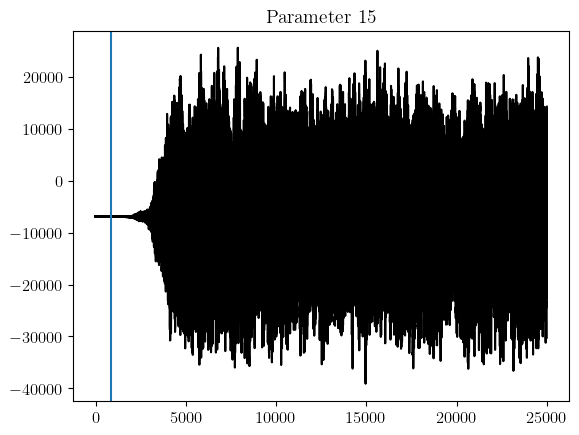

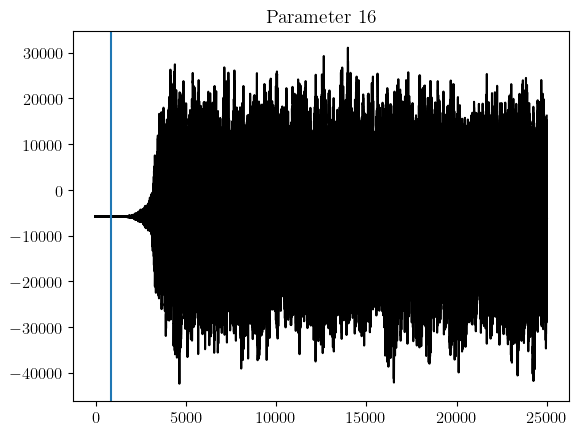

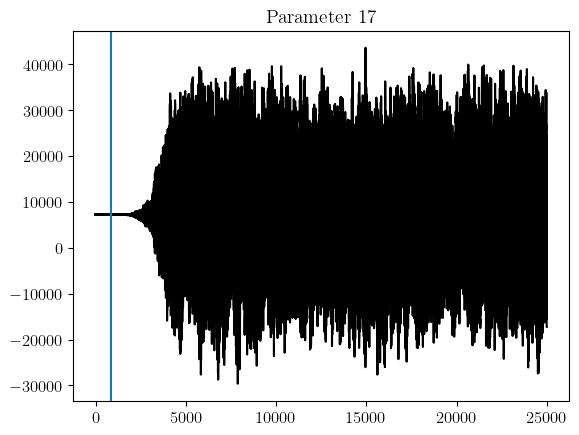

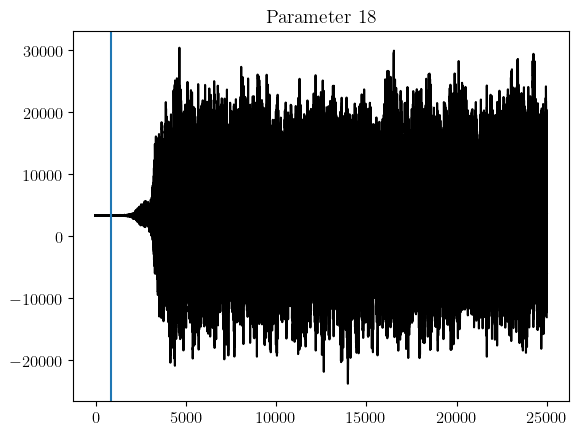

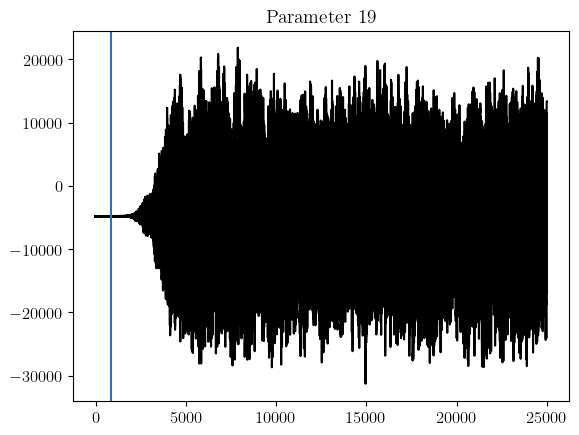

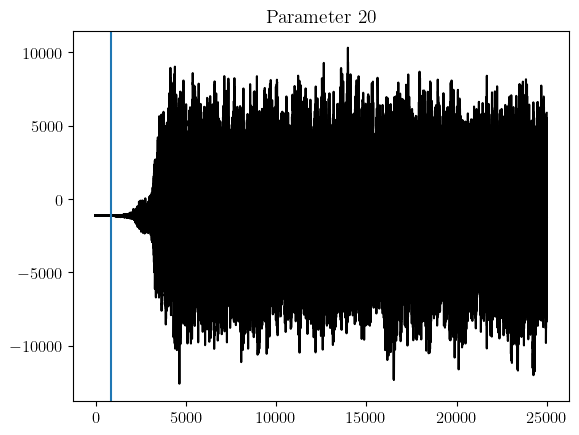

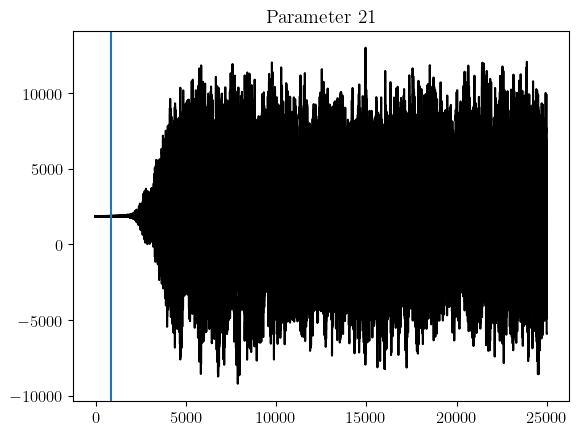

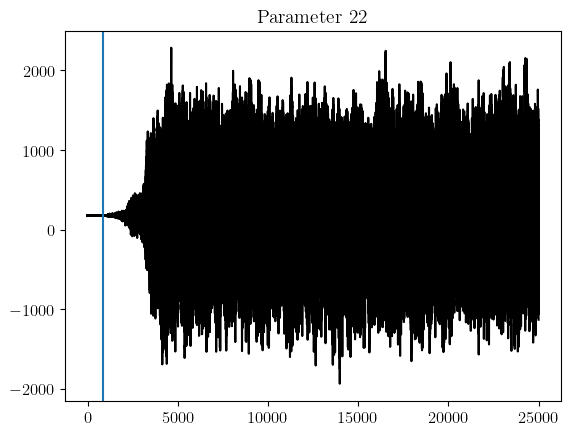

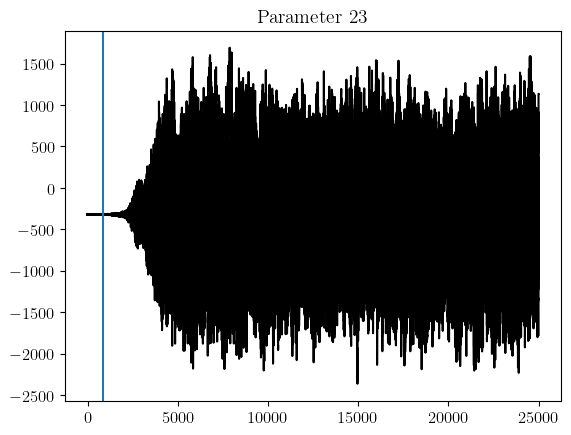

In [8]:
for i in range(2*(N+1)):
    fig, ax = plt.subplots()
    ax.plot(samples[:, :, i][:25000], 'k')
    ax.axvline(2*np.max(tau))
    ax.set_title(f'Parameter {i}')
    plt.show()

The integrated correlation time is biased because of the long burn-in. Manually choose how many samples to discard, then re-compute $\tau$:

In [9]:
new_tau = reader.get_autocorr_time(discard=10000)

In [10]:
new_tau

array([422.16266368, 407.56434003, 418.14795555, 411.83160275,
       423.88579621, 410.98391044, 430.34691827, 407.64194659,
       430.8417864 , 408.79830571, 425.64315905, 415.4486101 ,
       421.41510771, 421.0223165 , 419.17641287, 424.16495272,
       417.81543796, 425.92347404, 416.77511795, 426.9995943 ,
       415.83084131, 427.66372026, 414.99234595, 428.02626162])

In [11]:
emcee_samples = reader.get_chain(
    discard=10000,
    thin=int(np.mean(new_tau)/2),
    flat=True
    )

In [12]:
analytic_samples = np.loadtxt(run_dir / 'analytic_samples.dat')

In [13]:
sim_info = utils.load_cce_data(ID)
sim = sim_info['sim']
chif = sim.chif_mag
Mf = sim.Mf

t0_M = pd.read_csv('../data/t0_data_30_to_100.csv', index_col=0)
t0 = t0_M[str(ID)].values[N]

data = {
    'plus': np.real(sim.h[2, 2]),
    'cross': -np.imag(sim.h[2, 2]),
}

In [14]:
ls_fit = qnmfits.ringdown_fit(
    sim.times,
    sim.h[2, 2],
    modes=modes,
    Mf=Mf,
    chif=chif,
    t0=t0,
    t0_method='closest'
)

In [15]:
ls_re_c = np.real(ls_fit['C'])
ls_im_c = np.imag(ls_fit['C'])

ls_re_c_im_c = []
for re_c, im_c in zip(ls_re_c, ls_im_c):
    ls_re_c_im_c.append(re_c)
    ls_re_c_im_c.append(im_c)

Re-make the corner plot and save the thinned emcee samples:

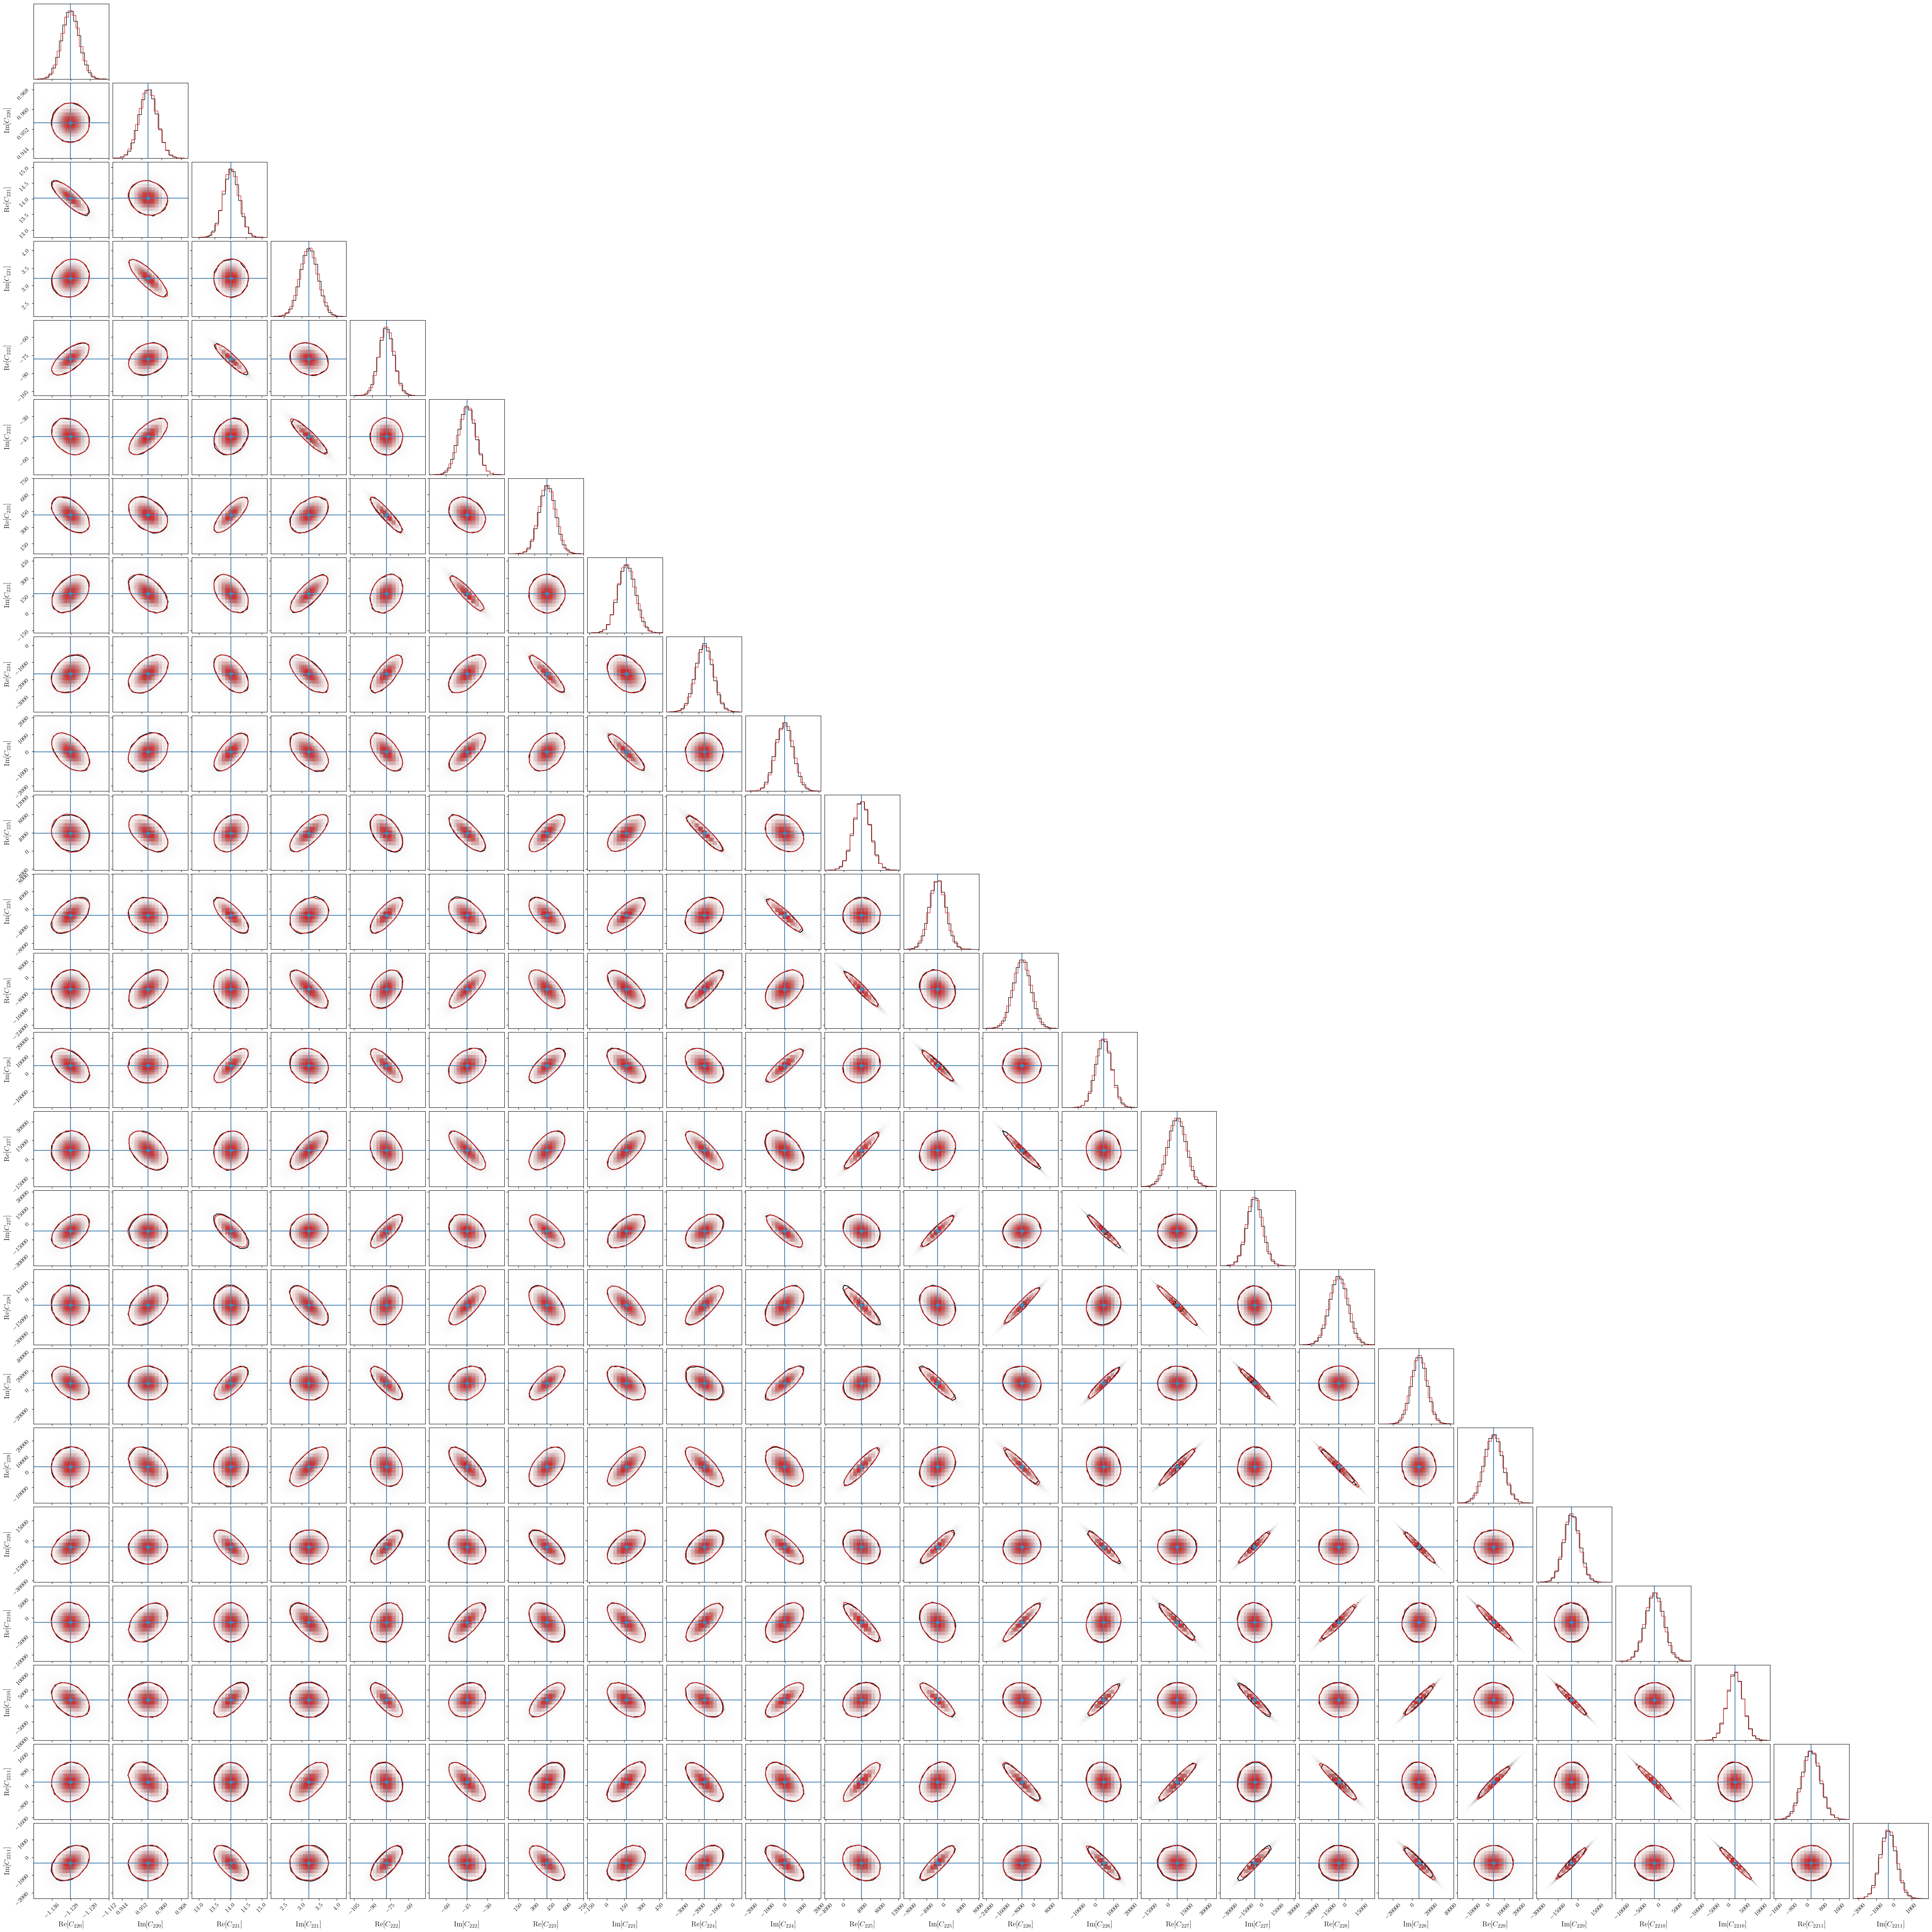

In [16]:
real_labels = [
    rf'$\mathrm{{Re}}[C_{{{ell}{m}{n}}}]$' for (ell, m, n, _) in modes
]
imag_labels = [
    rf'$\mathrm{{Im}}[C_{{{ell}{m}{n}}}]$' for (ell, m, n, _) in modes
]
labels = []
for real, imag in zip(real_labels, imag_labels):
    labels.append(real)
    labels.append(imag)

fig = corner.corner(
    analytic_samples,
    levels=[0.9],
    labels=labels,
    truths=ls_re_c_im_c,
    data_kwargs={
        'alpha': 0.005,
    },
    hist_kwargs={
        'density': True,
    }
)
corner.corner(
    emcee_samples,
    levels=[0.9],
    no_fill_contours=True,
    plot_datapoints=False,
    color='C3',
    hist_kwargs={
        'density': True,
    },
    fig=fig
)
fig.savefig(run_dir / 'corner_comparison.png', dpi=180)

In [17]:
analytic_re_c_samples = analytic_samples[:, 0::2]
analytic_im_c_samples = analytic_samples[:, 1::2]
analytic_c_samples = analytic_re_c_samples + 1j*analytic_im_c_samples
analytic_a_samples = np.abs(analytic_c_samples)
analytic_phi_samples = np.angle(analytic_c_samples)

emcee_re_c_samples = emcee_samples[:, 0::2]
emcee_im_c_samples = emcee_samples[:, 1::2]
emcee_c_samples = emcee_re_c_samples + 1j*emcee_im_c_samples
emcee_a_samples = np.abs(emcee_c_samples)
emcee_phi_samples = np.angle(emcee_c_samples)

In [18]:
a_labels = [
    rf'$A_{{{ell}{m}{n}}}$' for (ell, m, n, _) in modes
]
phi_labels = [
    rf'$\phi_{{{ell}{m}{n}}}$' for (ell, m, n, _) in modes
]

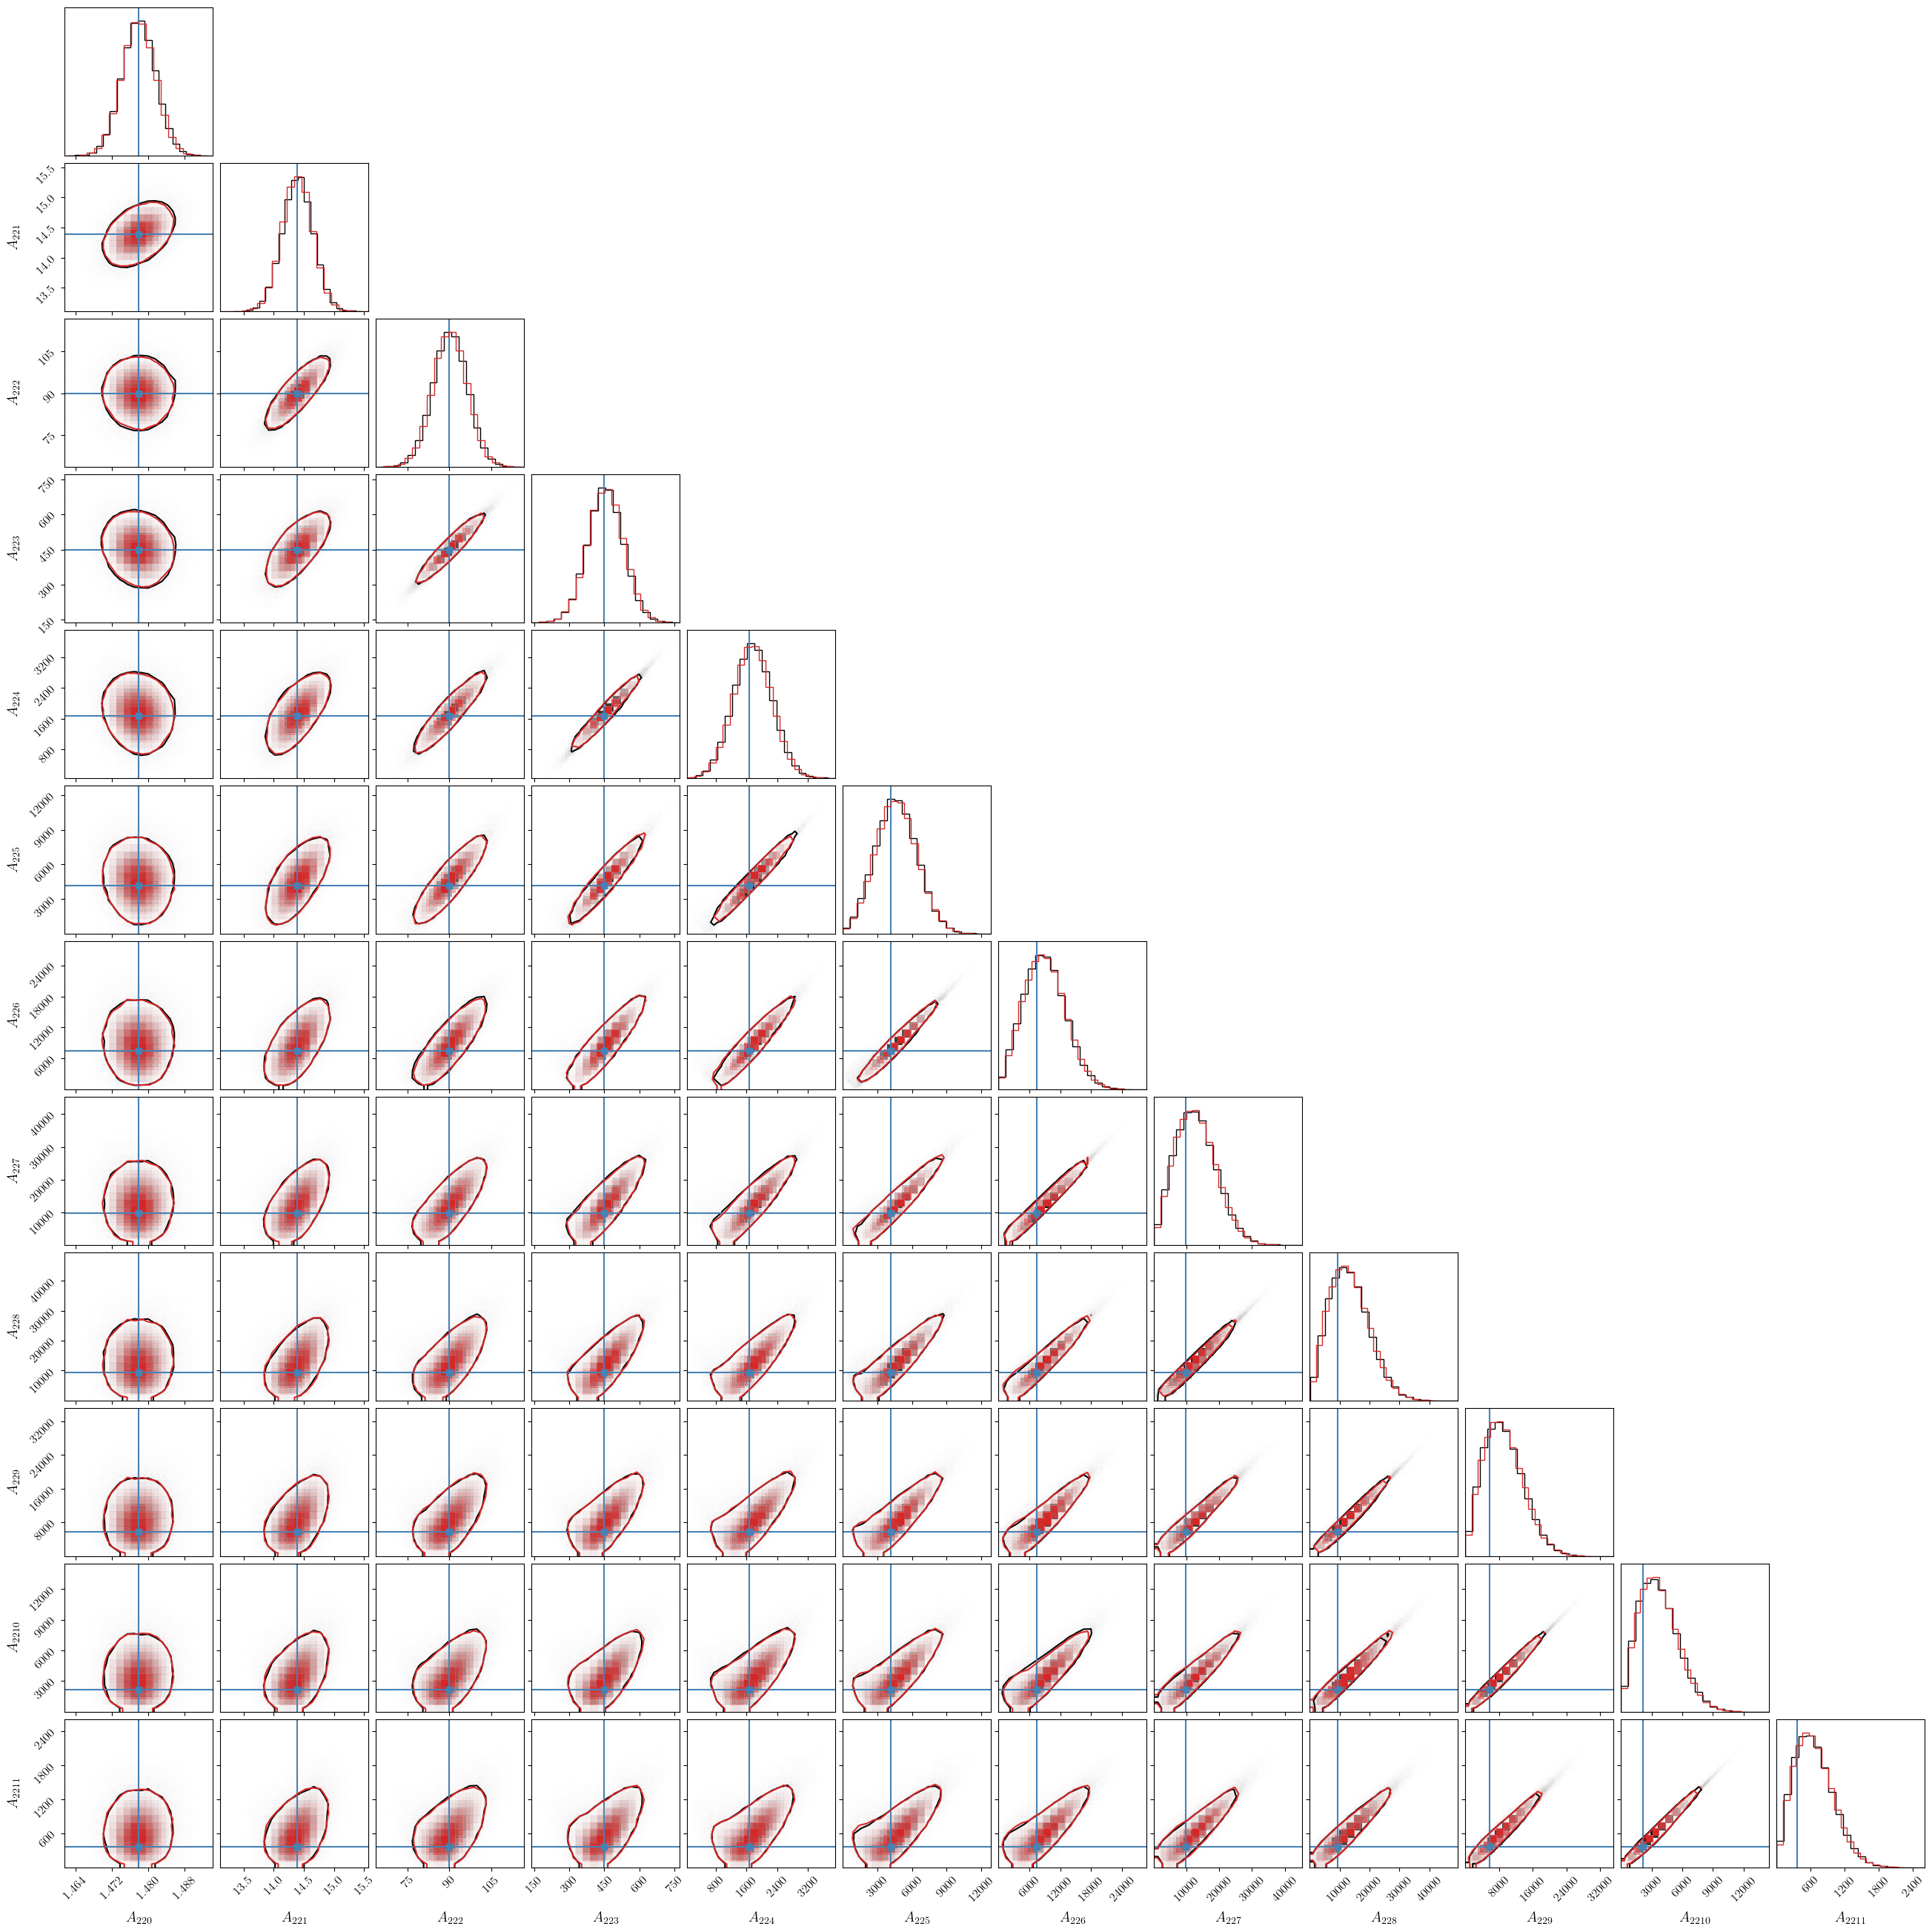

In [19]:
fig = corner.corner(
    analytic_a_samples,
    levels=[0.9],
    labels=a_labels,
    truths=np.abs(ls_fit['C']),
    data_kwargs={
        'alpha': 0.005,
    },
    hist_kwargs={
        'density': True,
    }
)
corner.corner(
    emcee_a_samples,
    levels=[0.9],
    no_fill_contours=True,
    plot_datapoints=False,
    color='C3',
    hist_kwargs={
        'density': True,
    },
    fig=fig
);

In [20]:
np.savetxt(run_dir / 'emcee_samples.dat', emcee_samples)

Plot waveforms

In [21]:
start_index = np.argmin((sim.times-t0)**2)
end_index = np.argmin((sim.times-t0-T)**2)

analysis_times = sim.times[start_index:end_index] - t0

analysis_data = {}
for pol, h in data.items():
    analysis_data[pol] = h[start_index:end_index]

In [22]:
omegas = []
for n in range(N+1):
    omegas.append(qnmfits.qnm.omega(2, 2, n, 1, chif=chif, Mf=Mf))

In [23]:
analytic_samples.shape, emcee_samples.shape

((50000, 24), (58176, 24))

In [24]:
sample_size = 10000
sample_params = rng.choice(emcee_samples, size=sample_size)
sample_params.shape

(10000, 24)

In [25]:
def ringdown_model(theta, times, frequencies):
    """
    Ringdown model class.

    Parameters
    ----------
    times : array-like
        The time values at which the model is evaluated.
    theta : dict
        Contains re[C] and im[C] for each requested mode.
    frequencies : array-like
        The frequencies corresponding to each qnm.
    """

    model = np.zeros_like(times, dtype=complex)

    real_amplitudes = theta[::2]
    imag_amplitudes = theta[1::2]

    for re_c, im_c, omega in zip(
        real_amplitudes, imag_amplitudes, frequencies
    ):
        model += (re_c+1j*im_c)*np.exp(-1j*omega*times)

    model_dict = {'plus': np.real(model), 'cross': -np.imag(model)}

    return model_dict

In [26]:
model_posterior_plus = []
model_posterior_cross = []
for sample in sample_params:
    model = ringdown_model(sample, analysis_times, omegas)
    model_posterior_plus.append(model['plus'])
    model_posterior_cross.append(model['cross'])

In [27]:
q5_plus = []
q50_plus = []
q95_plus = []

for i in range(len(analysis_times)):
    q5_plus.append(np.percentile([model[i] for model in model_posterior_plus], 5))
    q50_plus.append(np.percentile([model[i] for model in model_posterior_plus], 50))
    q95_plus.append(np.percentile([model[i] for model in model_posterior_plus], 95))

q5_plus = np.array(q5_plus)
q50_plus = np.array(q50_plus)
q95_plus = np.array(q95_plus)

In [28]:
q5_cross = []
q50_cross = []
q95_cross = []

for i in range(len(analysis_times)):
    q5_cross.append(np.percentile([model[i] for model in model_posterior_cross], 5))
    q50_cross.append(np.percentile([model[i] for model in model_posterior_cross], 50))
    q95_cross.append(np.percentile([model[i] for model in model_posterior_cross], 95))

q5_cross = np.array(q5_cross)
q50_cross = np.array(q50_cross)
q95_cross = np.array(q95_cross)

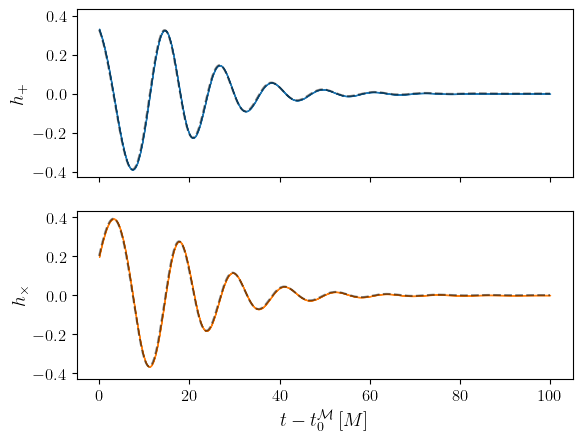

In [29]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

axs[0].fill_between(
    analysis_times, q5_plus, q95_plus, color='C0'
)
axs[0].plot(analysis_times, analysis_data['plus'], 'k', ls='--', alpha=0.5)

axs[1].fill_between(
    analysis_times, q5_cross, q95_cross, color='C1'
)
axs[1].plot(analysis_times, analysis_data['cross'], 'k', ls='--', alpha=0.5)

# axs[0].set_xlim(9, 11)
# axs[0].set_ylim(0.35, 0.38)

axs[0].set_ylabel(r'$h_+$')
axs[1].set_ylabel(r'$h_\times$')
axs[1].set_xlabel(r'$t - t_0^\mathcal{M}\, [M]$');

What is the combination of smallest amplitudes that works?

In [30]:
min_sum = np.inf
min_i = -1
for i, sample in enumerate(analytic_samples):
    real_amplitudes = sample[::2]
    imag_amplitudes = sample[1::2]
    magnitude_sum = np.sum(np.abs(real_amplitudes+ 1j*imag_amplitudes))
    if magnitude_sum < min_sum:
        min_sum = magnitude_sum
        min_i = i

In [31]:
min_sum, min_i

(np.float64(5322.859760310257), 46258)

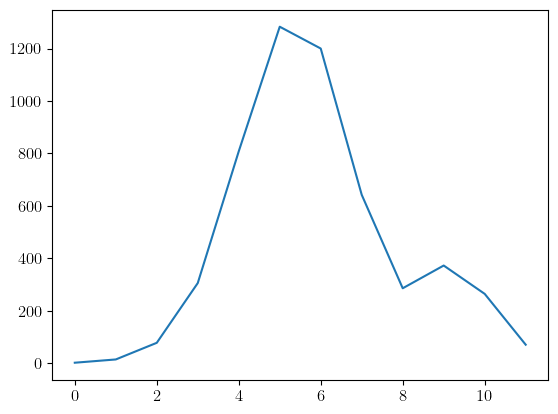

In [32]:
min_amp_sample = analytic_samples[min_i]
min_re_amp = min_amp_sample[::2]
min_im_amp = min_amp_sample[1::2]
min_mag_sample = np.abs(min_re_amp + 1j*min_im_amp)

fig, ax = plt.subplots()
ax.plot(min_mag_sample);

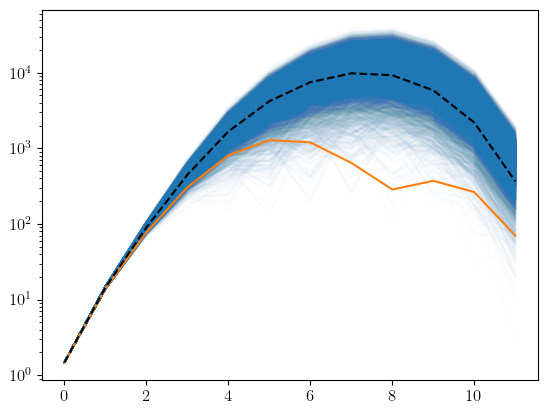

In [33]:
fig, ax = plt.subplots()
ax.set_yscale('log')

for sample in sample_params:
    real_amplitudes = sample[::2]
    imag_amplitudes = sample[1::2]
    magnitude_sample = np.abs(real_amplitudes + 1j*imag_amplitudes)
    ax.plot(magnitude_sample, color='C0', alpha=0.01)

ax.plot(min_mag_sample, color='C1')
ax.plot(np.abs(ls_fit['C']), color='k', ls='--')

Inspect mismatch distribution

In [34]:
mm_ls = ls_fit['mismatch']

In [35]:
mm_ls

np.float64(1.6824896020839475e-07)

In [36]:
mm_list = []
for model_plus, model_cross in zip(model_posterior_plus, model_posterior_cross):
    mm_list.append(
        qnmfits.mismatch(
            analysis_times, 
            model_plus - 1j*model_cross,
            analysis_data['plus'] - 1j*analysis_data['cross']
        )
    )
mm_list = np.array(mm_list)

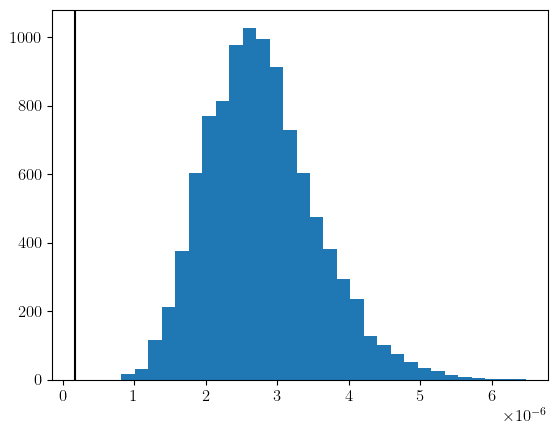

In [37]:
fig, ax = plt.subplots()
ax.hist(mm_list, bins=30)
ax.axvline(mm_ls, c='k');